In [2]:
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib import cm
#matplotlib format
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'],'size':10})
rc('mathtext',**{'default':'regular'})
get_ipython().run_line_magic('matplotlib', 'inline')
get_ipython().run_line_magic('config', "InlineBackend.figure_format = 'retina'")
from pickle import dump, load
import torch
from scipy import interpolate 
import pandas as pd

cmap = cm.get_cmap('plasma')
rgba = cmap(0.6)

/scratch/local/u1262705/237149/ipykernel_235738/477404827.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('plasma')


In [3]:
def se_kernel(x1, x2, l, width):
    """
    Computes the squared exponential kernel between the tensors x and y with hyper-parameters l and width.
    N corresponds to the number of samples and D corresponds to the number of dimensions of the input function.
    
    Parameters
    ----------
    
    x: Tensor [N,D]
        Feature vector for N samples with D dimensions each
    
    y: Tensor [N,D]
        Feature vector for N samples with D dimensions each
        
    l: Tensor [D]
        Lengthscale hyper parameter
        
    width: Float
        Width hyper parameter
    """
    K = width**2 * torch.exp(-(torch.cdist(x1/l,x2/l,p=2)**2)/2)
    return K

def surrogate(Xi, Xd, l, width, y, KddInv):
    """
    Computes the gaussian process estimate of the structure factor given a set of pair potential parameters. 
    
    Parameters
    ----------
    
    Xi: Tensor [η*M,D]
        Feature vector for M potential samples at η r evaluations with D dimensions each. This 
        corresponds to the points you wish to infer.
    
    Xd: Tensor [N,D]
        Feature vector for N samples with D dimensions each. This corresponds to the points you trained on.
        
    l: Tensor [D]
        Lengthscale hyper parameter.
        
    width: Float
        Width hyper parameter
        
    y: Tensor [N,1]
        Output feature vector corresponding to the Xd training set.  
        
    KddInv: Tensor [N,N]
        This is the inverted kernel matrix of the training set Xd
       
    Returns
    -------
       
    μ: Tensor [η,N]
        The mean estimate for each g(r,n,sigma,epsilon) given in Xi. 
        
    """
    Kid = se_kernel(Xi, Xd, l, width)
    return 1 +  (Kid @ KddInv @ (y-1))

def local_surrogate_pmf(Xi, Xd, l, width, y, KddInv, μd):
    """
    Computes the subset gaussian process estimate of the structure factor given a set of pair potential parameters. 
    
    Parameters
    ----------
    
    Xi: Tensor [M,D]
        Feature vector for M samples with D dimensions each. This corresponds to the points you wish to infer.
    
    Xd: Tensor [M,D]
        Feature vector for N samples with D dimensions each. This corresponds to the points you trained on.
        
    l: Tensor [D]
        Lengthscale hyper parameter.
        
    width: Float
        Width hyper parameter
        
    KddInv: Tensor [N,N]
        This is the inverted kernel matrix of the training set Xd
        
    Returns
    -------
    
    μ: Tensor [η,N]
        The mean estimate for each g(r) at each potential. The g(r)'s are organized in vertical lines where the column
        dimension indexes the potential parameters. 
        
    """
    V = torch.stack([((n/(n-6))*((n/6)**((6)/(n-6))))*e*((s/r)**n - (s/r)**6) for n,s,e in zip(Xi[:,0],Xi[:,1],Xi[:,2])])
    μ = torch.exp(-V/kbT)
    Kid = se_kernel(Xi, Xd, l, width)
    return (μ +(Kid @ KddInv) @ (y-μd)).T

# Import the training data generated by 1_sample_gen.ipynb

rmin = 0.0118331810091873
rmax = 15.512161254882812
rnum = 73

k   = 3.29982916e-27 #boltzmann constant,   [kcal/K/particle]   
av  = 6.0223e23      #avagadro number,      [particle/mol]  
T   = 42.2           #temperature,          [K]
kbT = k * av * T

input_dict = load(open('training_data/xs.p', 'rb'))
xd = input_dict['xs'].reshape(3*320,3)

input_dict = load(open('training_data/rdfs.p', 'rb'))
model_rdf = input_dict['rdfs']

r = torch.linspace(rmin,rmax,rnum)

n = len(xd)
η = len(r)
XdClassic = torch.zeros(n*η,4)
yClassic = torch.zeros(n*η)

k = 0 # Row index in Xd matrix and y vector.
for i in range(n):
    for j in range(η):
        # Xd_k = (n,σ,ϵ,q)
        XdClassic[k] = torch.tensor([xd[i][0],xd[i][1],xd[i][2],r[j]])
        yClassic[k] = model_rdf[i][j]
        k += 1
        
yClassic = torch.unsqueeze(yClassic,dim=0).transpose(0,1)

# Remake the Xd matrix for the subset matrix 
Xd = torch.tensor(xd).float()
y = model_rdf.float()

index = torch.arange(0,len(xd),1)

/scratch/local/u1262705/237149/ipykernel_235738/4090271795.py:130: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Xd = torch.tensor(xd).float()


In [4]:
input_dict = load(open('training_data/xs.p', 'rb'))
xs = input_dict['xs']

input_dict = load(open('testing_data/xs_test.p', 'rb'))
xs_test = input_dict['xs_test']

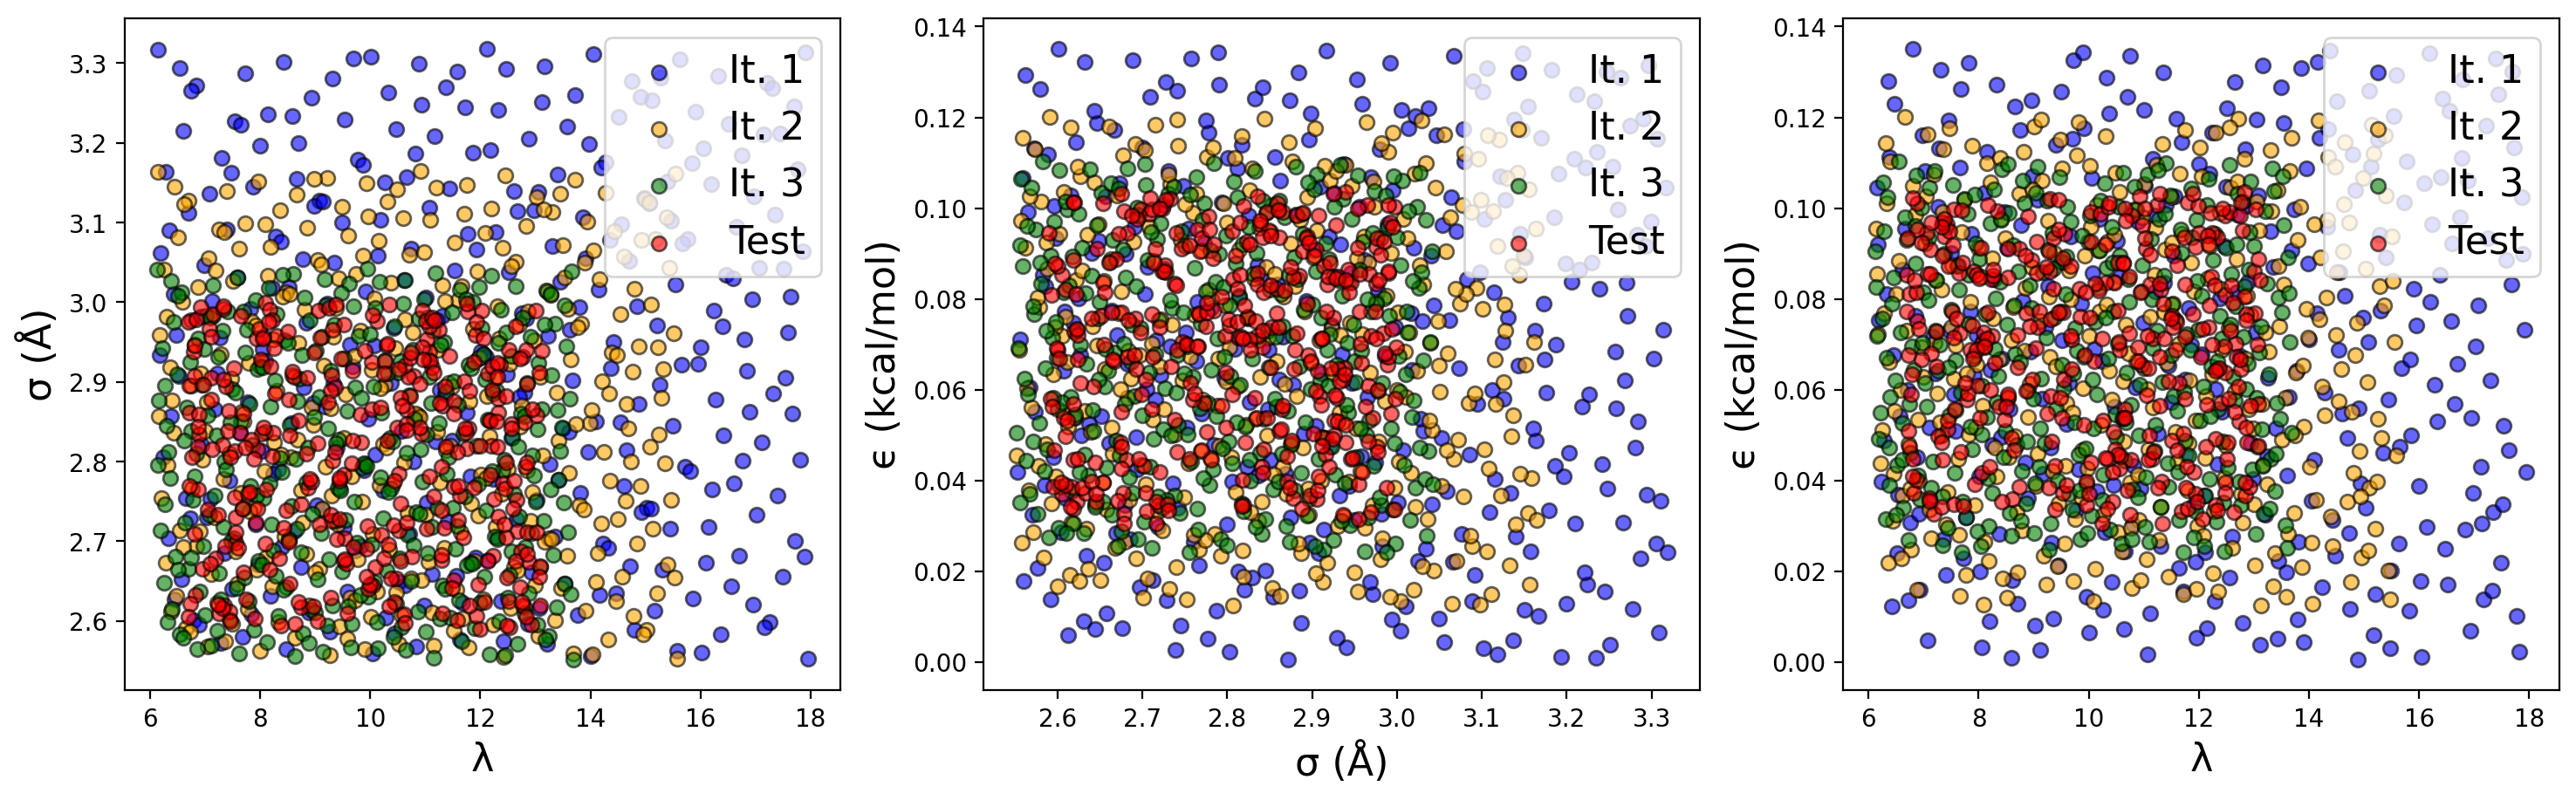

In [5]:
#Training and Test Set Figure
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
axs[0].scatter(xs[0,:,0], xs[0,:,1], color = 'b', alpha = 0.6, edgecolors = 'k', label = 'It. 1')
axs[0].scatter(xs[1,:,0], xs[1,:,1], color = 'orange', alpha = 0.6, edgecolors = 'k', label = 'It. 2')
axs[0].scatter(xs[2,:,0], xs[2,:,1], color = 'green', alpha = 0.6, edgecolors = 'k', label = 'It. 3')
axs[0].scatter(xs_test[:,0], xs_test[:,1], color = 'r', alpha = 0.6, edgecolors = 'k', label = 'Test')
axs[0].legend(fontsize = 16)
axs[0].set_xlabel('λ', fontsize = 16)
axs[0].set_ylabel('σ (Å)', fontsize = 16)

axs[1].scatter(xs[0,:,1], xs[0,:,2], color = 'b', alpha = 0.6, edgecolors = 'k', label = 'It. 1')
axs[1].scatter(xs[1,:,1], xs[1,:,2], color = 'orange', alpha = 0.6, edgecolors = 'k', label = 'It. 2')
axs[1].scatter(xs[2,:,1], xs[2,:,2], color = 'green', alpha = 0.6, edgecolors = 'k', label = 'It. 3')
axs[1].scatter(xs_test[:,1], xs_test[:,2], color = 'r', alpha = 0.6, edgecolors = 'k', label = 'Test')
axs[1].legend(fontsize = 16)
axs[1].set_xlabel('σ (Å)', fontsize = 16)
axs[1].set_ylabel('ϵ (kcal/mol)', fontsize = 16)

axs[2].scatter(xs[0,:,0], xs[0,:,2], color = 'b', alpha = 0.6, edgecolors = 'k', label = 'It. 1')
axs[2].scatter(xs[1,:,0], xs[1,:,2], color = 'orange', alpha = 0.6, edgecolors = 'k', label = 'It. 2')
axs[2].scatter(xs[2,:,0], xs[2,:,2], color = 'green', alpha = 0.6, edgecolors = 'k', label = 'It. 3')
axs[2].scatter(xs_test[:,0], xs_test[:,2], color = 'r', alpha = 0.6, edgecolors = 'k', label = 'Test')
axs[2].legend(fontsize = 16)
axs[2].set_xlabel('λ', fontsize = 16)
axs[2].set_ylabel('ϵ (kcal/mol)', fontsize = 16)
# plt.savefig('figures/trainingset.png', dpi = 600, pad_inches = 0.2)
plt.show()

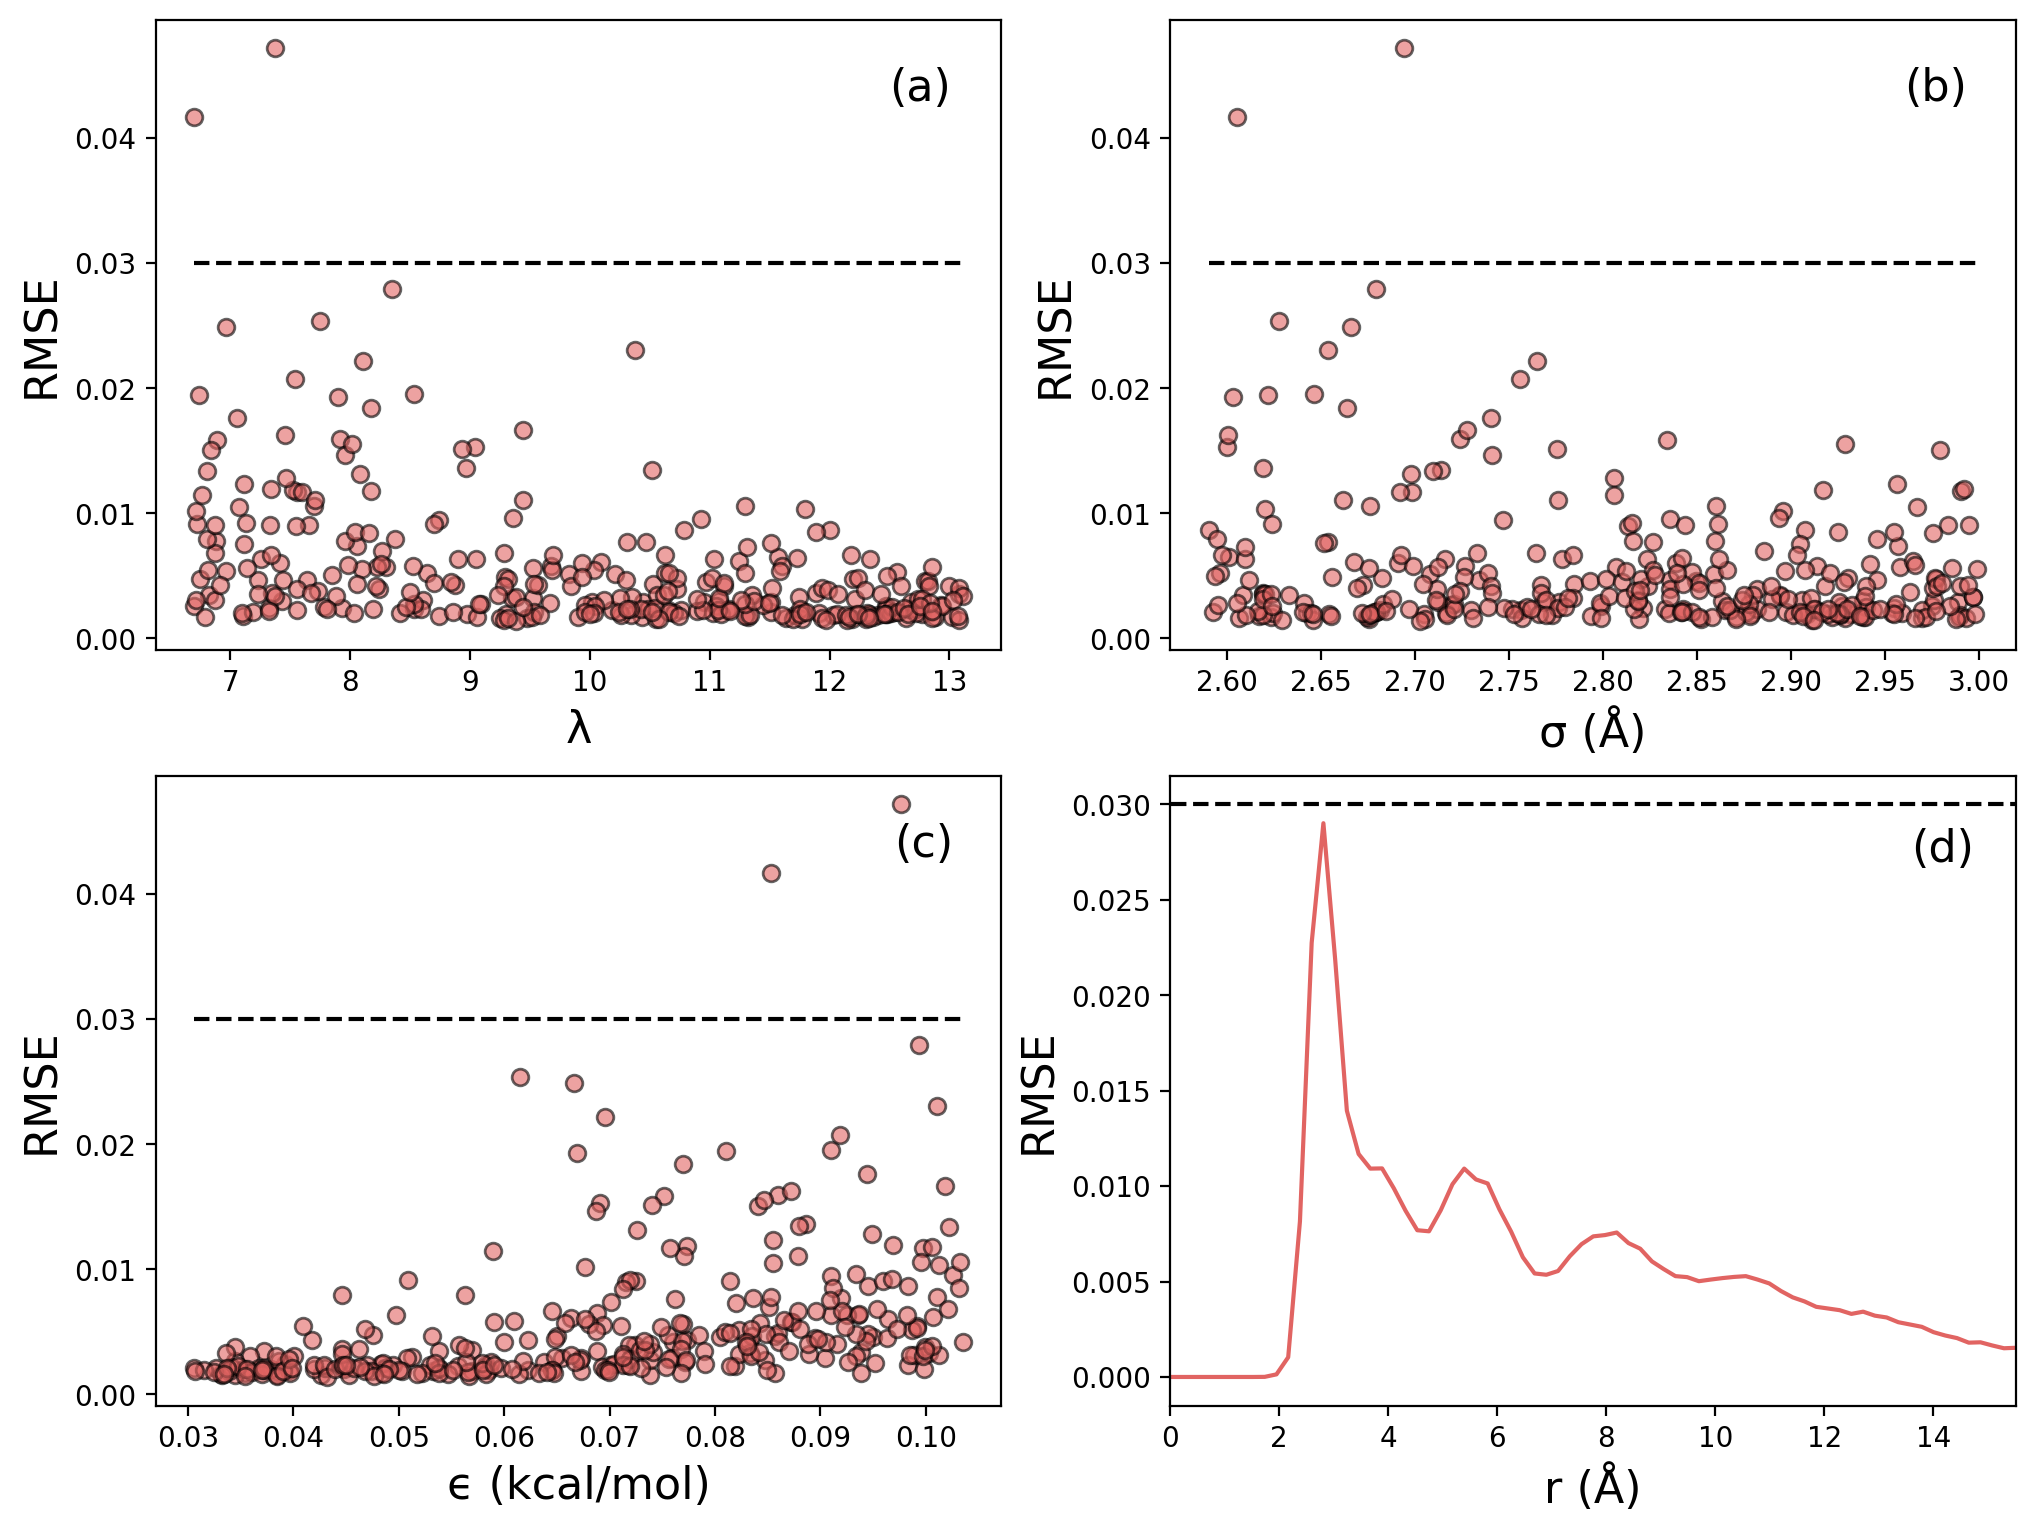

In [6]:
nsims = 320
ndims = 3
input_dict = load(open('testing_data/xs_test.p', 'rb'))
xs_test = input_dict['xs_test']

input_dict = load(open('testing_data/rdfs_test.p', 'rb'))
rdfs_test_bruh = input_dict['rdfs']

arr = [3.3110e+00, 4.5928e-02, 9.8081e-03, 9.4022e-02, 7.2281e-04]
l = torch.tensor([arr[0],arr[1],arr[2]]).float()
w = torch.tensor(arr[3]).float()
σn = torch.tensor(arr[4]).float()
Kdd = se_kernel(Xd,Xd,l,w) + torch.eye(len(Xd))*σn
KddInv = torch.linalg.inv(Kdd)
Xi = xs_test.float()

Vd = torch.stack([((n/(n-6))*((n/6)**((6)/(n-6))))*e*((s/r)**n - (s/r)**6) for n,s,e in zip(Xd[:,0],Xd[:,1],Xd[:,2])])
μd = torch.exp(-Vd/kbT).float() #PMF prior mean

GPOut = local_surrogate_pmf(Xi, Xd, l, w, y, KddInv, μd)
RMSE = torch.sqrt(torch.mean((GPOut.T - rdfs_test_bruh)**2,dim=0))
RMSE_total = torch.sqrt(torch.mean((GPOut.T - rdfs_test_bruh)**2))

err = torch.zeros(320)
for i in range(320):
    err[i] = torch.sqrt(torch.sum((GPOut.T[i] - rdfs_test_bruh[i])**2)/73)
    
fig, axs = plt.subplots(2, 2, figsize=(12, 9))
axs[0,0].scatter(xs_test[:,0], err, color = rgba, alpha = 0.6, edgecolors = 'k')
axs[0,0].hlines(0.03,xmin=min(xs_test[:,0]),xmax=max(xs_test[:,0]),color='k',linestyle='dashed')
axs[0,0].set_xlabel('λ', fontsize = 16)
axs[0,0].set_ylabel('RMSE', fontsize = 16)
axs[0,0].text(12.5, 0.043, '(a)', fontsize = 16)
axs[0,1].hlines(0.03,xmin=min(xs_test[:,1]),xmax=max(xs_test[:,1]),color='k',linestyle='dashed')
axs[0,1].scatter(xs_test[:,1], err, color = rgba, alpha = 0.6, edgecolors = 'k')
axs[0,1].set_xlabel('σ (Å)', fontsize = 16)
axs[0,1].set_ylabel('RMSE', fontsize = 16)
axs[0,1].text(2.96, 0.043, '(b)', fontsize = 16)
axs[1,0].scatter(xs_test[:,2], err, color = rgba, alpha = 0.6, edgecolors = 'k')
axs[1,0].hlines(0.03,xmin=min(xs_test[:,2]),xmax=max(xs_test[:,2]),color='k',linestyle='dashed')
axs[1,0].set_xlabel('ϵ (kcal/mol)', fontsize = 16)
axs[1,0].set_ylabel('RMSE', fontsize = 16)
axs[1,0].text(0.097, 0.043, '(c)', fontsize = 16)
axs[1,1].plot(r,RMSE, color = rgba, linestyle = '-')
axs[1,1].set_xlim(0, r[-1])
axs[1,1].set_xlabel('r (Å)', fontsize = 16)
axs[1,1].set_ylabel('RMSE', fontsize = 16)
axs[1,1].hlines(0.03,xmin=rmin,xmax=rmax,color='k',linestyle='dashed')
axs[1,1].text(13.6, 0.027, '(d)', fontsize = 16)
# plt.savefig('figures/rmse', dpi = 600)
plt.show()

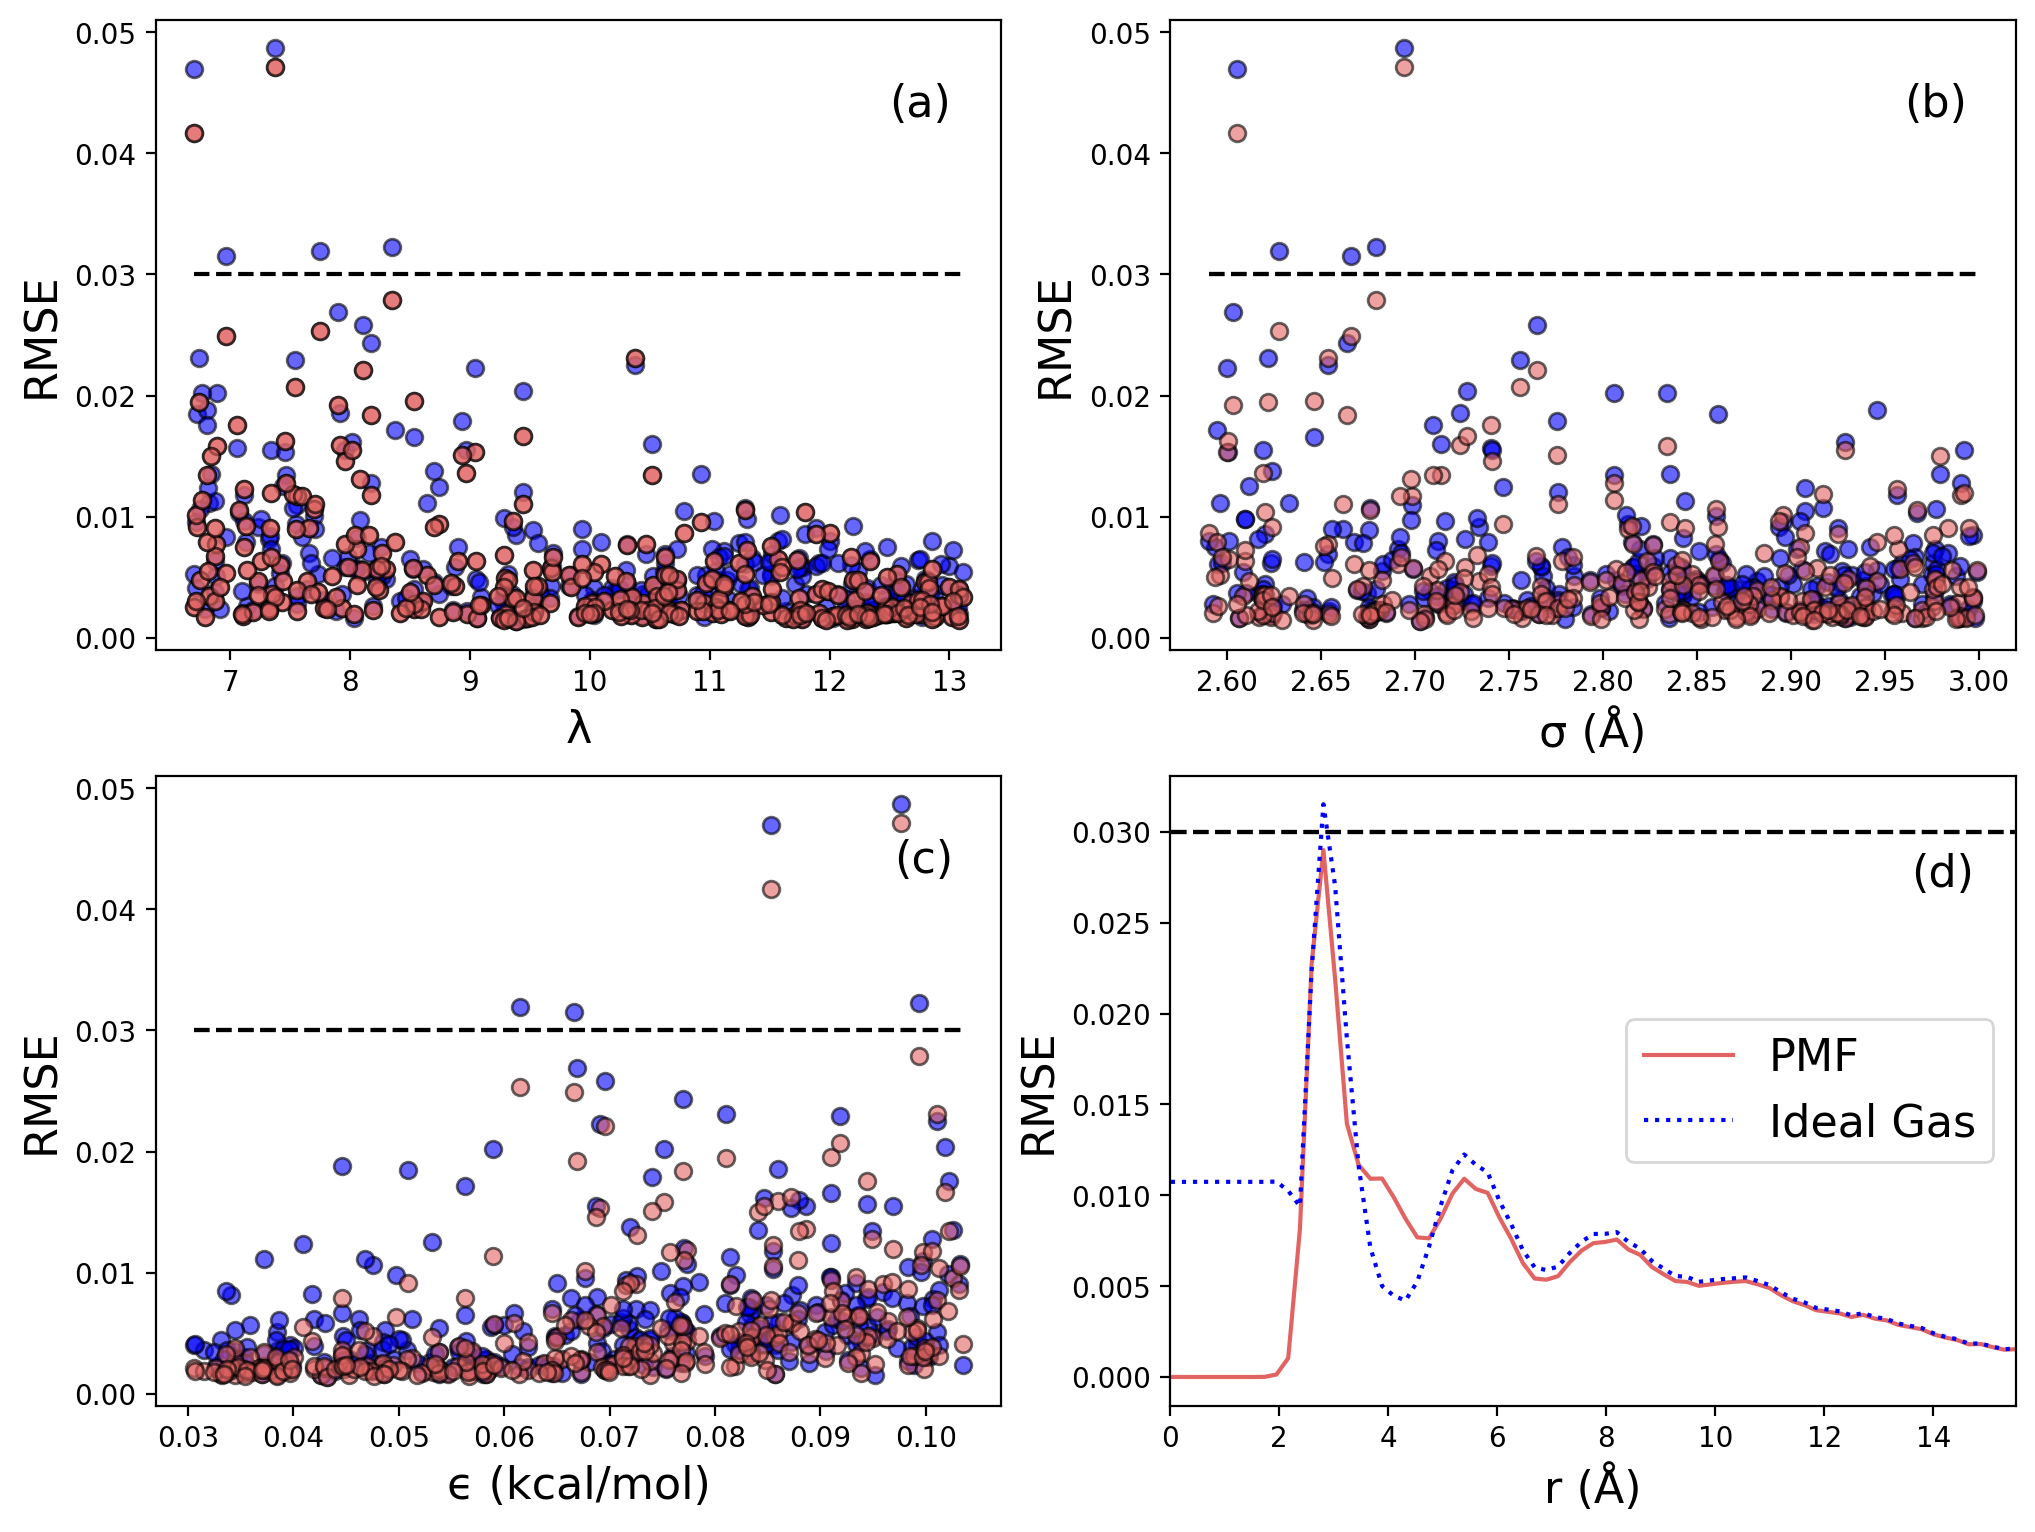

In [10]:
#Ideal vs PMF

def local_surrogate_ideal(Xi, Xd, l, width, y, KddInv):
    """
    Computes the subset gaussian process estimate of the structure factor given a set of pair potential parameters. 
    
    Parameters
    ----------
    
    Xi: Tensor [M,D]
        Feature vector for M samples with D dimensions each. This corresponds to the points you wish to infer.
    
    Xd: Tensor [M,D]
        Feature vector for N samples with D dimensions each. This corresponds to the points you trained on.
        
    l: Tensor [D]
        Lengthscale hyper parameter.
        
    width: Float
        Width hyper parameter
        
    KddInv: Tensor [N,N]
        This is the inverted kernel matrix of the training set Xd
        
    Returns
    -------
    
    μ: Tensor [η,N]
        The mean estimate for each g(r) at each potential. The g(r)'s are organized in vertical lines where the column
        dimension indexes the potential parameters. 
        
    """
    Kid = se_kernel(Xi, Xd, l, width)
    return (1 +(Kid @ KddInv) @ (y-1)).T

arr = [3.5815e+00, 4.8367e-02, 9.3155e-03, 9.4958e-02, 8.2605e-04]
l = torch.tensor([arr[0],arr[1],arr[2]]).float()
w = torch.tensor(arr[3]).float()
σn = torch.tensor(arr[4]).float()
Kdd = se_kernel(Xd,Xd,l,w) + torch.eye(len(Xd))*σn
KddInv = torch.linalg.inv(Kdd)
Xi = xs_test.float()

Vd = torch.stack([((n/(n-6))*((n/6)**((6)/(n-6))))*e*((s/r)**n - (s/r)**6) for n,s,e in zip(Xd[:,0],Xd[:,1],Xd[:,2])])
μd = torch.exp(-Vd*0).float() #ideal gas prior mean

GPOut = local_surrogate_ideal(Xi, Xd, l, w, y, KddInv)
RMSE1 = torch.sqrt(torch.mean((GPOut.T - rdfs_test_bruh)**2,dim=0))
RMSE_total1 = torch.sqrt(torch.mean((GPOut.T - rdfs_test_bruh)**2))

err1 = torch.zeros(320)
for i in range(320):
    err1[i] = torch.sqrt(torch.sum((GPOut.T[i] - rdfs_test_bruh[i])**2)/73)
    
fig, axs = plt.subplots(2, 2, figsize=(12, 9))
#Ideal Gas
axs[0,0].scatter(xs_test[:,0], err1, color = 'b', alpha = 0.6, edgecolors = 'k')
axs[0,0].scatter(xs_test[:,0], err, color = rgba, alpha = 0.6, edgecolors = 'k')
axs[0,0].hlines(0.03,xmin=min(xs_test[:,0]),xmax=max(xs_test[:,0]),color='k',linestyle='dashed')
axs[0,0].set_xlabel('λ', fontsize = 16)
axs[0,0].set_ylabel('RMSE', fontsize = 16)

axs[0,1].hlines(0.03,xmin=min(xs_test[:,1]),xmax=max(xs_test[:,1]),color='k',linestyle='dashed')
axs[0,1].scatter(xs_test[:,1], err1, color = 'b', alpha = 0.6, edgecolors = 'k')
axs[0,1].set_xlabel('σ (Å)', fontsize = 16)
axs[0,1].set_ylabel('RMSE', fontsize = 16)

axs[1,0].scatter(xs_test[:,2], err1, color = 'b', alpha = 0.6, edgecolors = 'k')
axs[1,0].hlines(0.03,xmin=min(xs_test[:,2]),xmax=max(xs_test[:,2]),color='k',linestyle='dashed')
axs[1,0].set_xlabel('ϵ (kcal/mol)', fontsize = 16)
axs[1,0].set_ylabel('RMSE', fontsize = 16)

axs[1,1].set_xlim(0, r[-1])
axs[1,1].set_xlabel('r (Å)', fontsize = 16)
axs[1,1].set_ylabel('RMSE', fontsize = 16)
axs[1,1].hlines(0.03,xmin=rmin,xmax=rmax,color='k',linestyle='dashed')

#PMF
axs[0,0].scatter(xs_test[:,0], err, color = rgba, alpha = 0.6, edgecolors = 'k')

axs[0,0].text(12.5, 0.043, '(a)', fontsize = 16)
axs[0,1].hlines(0.03,xmin=min(xs_test[:,1]),xmax=max(xs_test[:,1]),color='k',linestyle='dashed')
axs[0,1].scatter(xs_test[:,1], err, color = rgba, alpha = 0.6, edgecolors = 'k')
axs[0,1].set_xlabel('σ (Å)', fontsize = 16)
axs[0,1].set_ylabel('RMSE', fontsize = 16)
axs[0,1].text(2.96, 0.043, '(b)', fontsize = 16)
axs[1,0].scatter(xs_test[:,2], err, color = rgba, alpha = 0.6, edgecolors = 'k')
axs[1,0].hlines(0.03,xmin=min(xs_test[:,2]),xmax=max(xs_test[:,2]),color='k',linestyle='dashed')
axs[1,0].set_xlabel('ϵ (kcal/mol)', fontsize = 16)
axs[1,0].set_ylabel('RMSE', fontsize = 16)
axs[1,0].text(0.097, 0.043, '(c)', fontsize = 16)
axs[1,1].plot(r,RMSE, color = rgba, label = 'PMF', linestyle = '-')
axs[1,1].plot(r,RMSE1, color = 'b', label = 'Ideal Gas', linestyle = ':')
axs[1,1].set_xlim(0, r[-1])
axs[1,1].set_xlabel('r (Å)', fontsize = 16)
axs[1,1].set_ylabel('RMSE', fontsize = 16)
axs[1,1].hlines(0.03,xmin=rmin,xmax=rmax,color='k',linestyle='dashed')
axs[1,1].text(13.6, 0.027, '(d)', fontsize = 16)
plt.legend(fontsize = 16, loc = 'center right')
plt.savefig('figures/rmse_igvspmf', dpi = 600)
plt.show()

In [8]:
print("Attempting to Load Chain...")

input_dict = load(open('mcmc/MCMCSamplesRDF_PMF.p', 'rb'))
chain = input_dict['chain']
autocorr = input_dict['autocorr']

loadedChain = True

print("Success!")

postSamps = torch.tensor(chain).reshape(10000*160,4).float()[::int(autocorr)]
postSamps = postSamps[torch.where((postSamps[:,1] > 2.4) & (postSamps[:,1] < 3.0))]

n_samps  = postSamps[:,0]
σ_samps  = postSamps[:,1]
ϵ_samps  = postSamps[:,2]
σn_samps = postSamps[:,3]

Attempting to Load Chain...
Success!


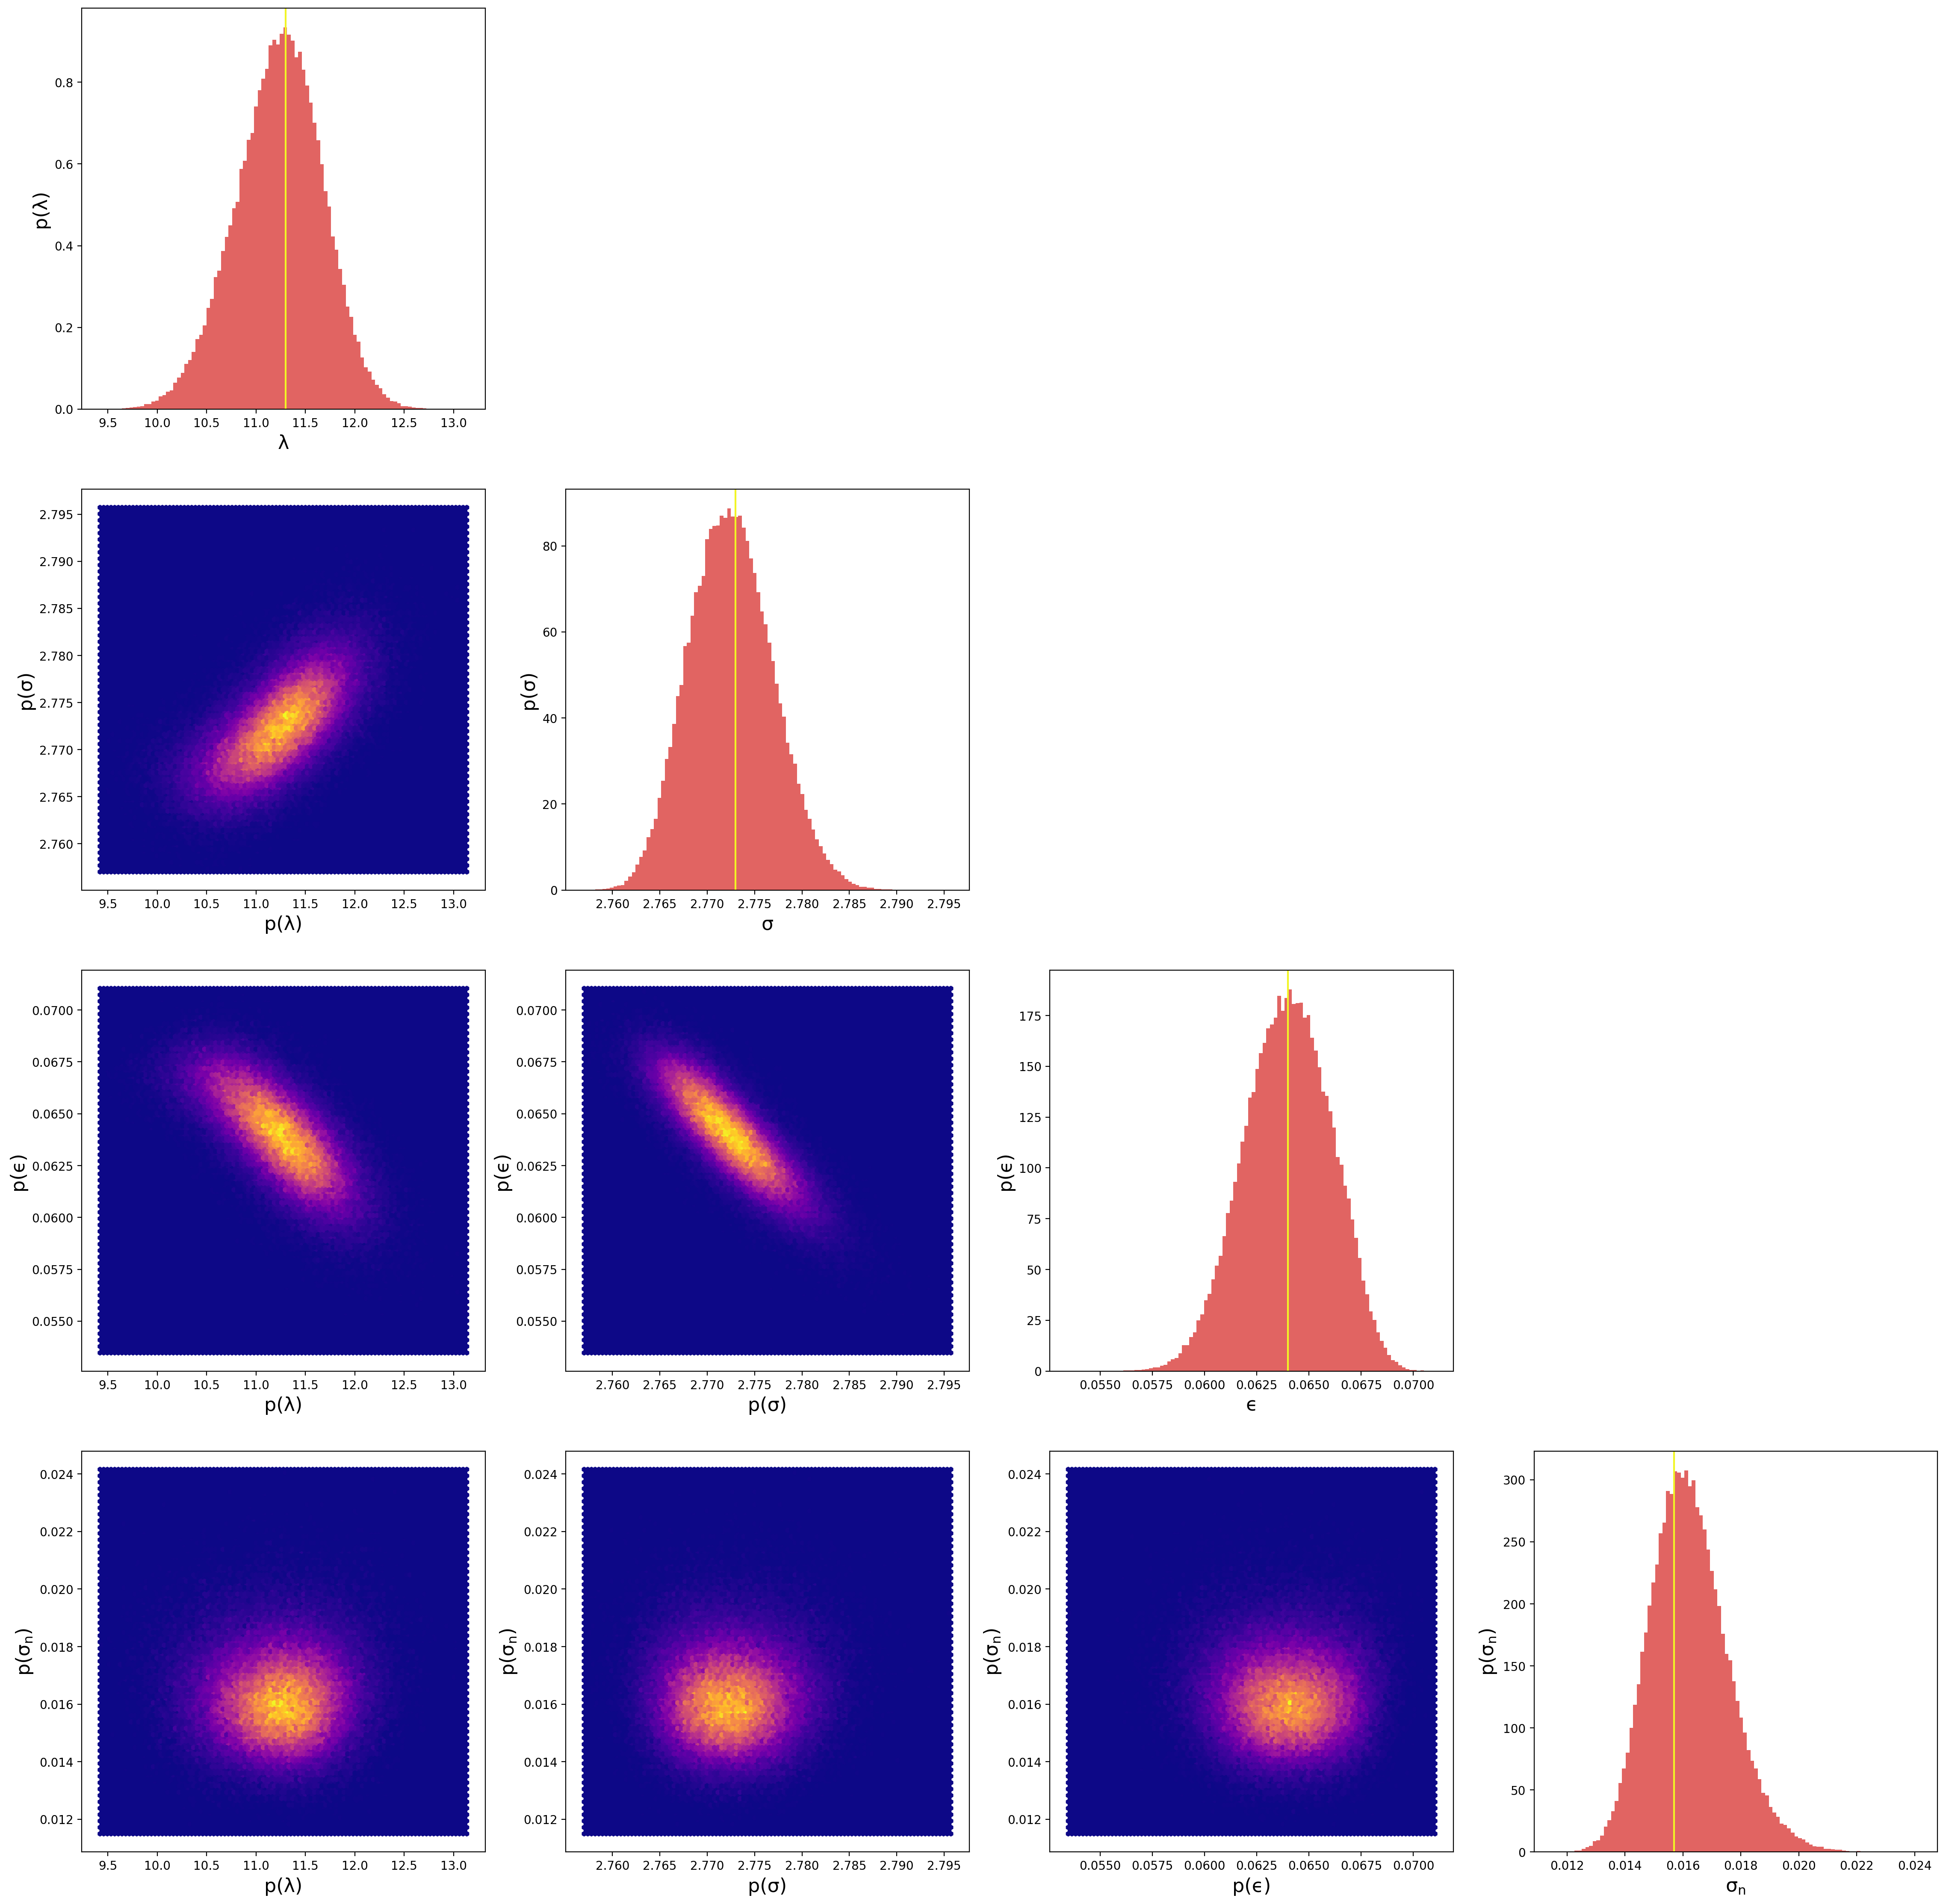

In [9]:
fig, axs = plt.subplots(4, 4, figsize=(28, 28))
fig.delaxes(axs[0,1])
fig.delaxes(axs[0,2])
fig.delaxes(axs[0,3])
fig.delaxes(axs[1,2])
fig.delaxes(axs[1,3])
fig.delaxes(axs[2,3])
axs[0,0].set_xlabel('λ', fontsize = 16)
axs[0,0].set_ylabel('p(λ)', fontsize = 16)
axs[0,0].hist(n_samps,density = True,bins=100, color = rgba)
axs[0,0].hist(n_samps,density = True,bins=100, color = rgba)
axs[0,0].axvline(11.3,0, 1, color = cmap(0.99))
axs[1,0].set_xlabel('p(λ)', fontsize = 16)
axs[1,0].set_ylabel('p(σ)', fontsize = 16)
axs[1,0].hexbin(n_samps, σ_samps, cmap = cmap)
axs[1,1].set_xlabel('σ', fontsize = 16)
axs[1,1].set_ylabel('p(σ)', fontsize = 16)
axs[1,1].hist(σ_samps,density = True,bins=100, color = rgba)
axs[1,1].axvline(2.773, 0, 1, color = cmap(0.99))
axs[2,0].set_xlabel('p(λ)', fontsize = 16)
axs[2,0].set_ylabel('p(ϵ)', fontsize = 16)
axs[2,0].hexbin(n_samps, ϵ_samps, cmap = cmap)
axs[2,1].set_xlabel('p(σ)', fontsize = 16)
axs[2,1].set_ylabel('p(ϵ)', fontsize = 16)
axs[2,1].hexbin(σ_samps, ϵ_samps, cmap = cmap)
axs[2,2].set_xlabel('ϵ', fontsize = 16)
axs[2,2].set_ylabel('p(ϵ)', fontsize = 16)
axs[2,2].hist(ϵ_samps,density = True,bins=100, color = rgba)
axs[2,2].axvline(0.064,0, 1, color = cmap(0.99))
axs[3,0].set_xlabel('p(λ)', fontsize = 16)
axs[3,0].set_ylabel('p(σ$_n$)', fontsize = 16)
axs[3,0].hexbin(n_samps, σn_samps, cmap = cmap)
axs[3,1].set_xlabel('p(σ)', fontsize = 16)
axs[3,1].set_ylabel('p(σ$_n$)', fontsize = 16)
axs[3,1].hexbin(σ_samps, σn_samps, cmap = cmap)
axs[3,2].set_xlabel('p(ϵ)', fontsize = 16)
axs[3,2].set_ylabel('p(σ$_n$)', fontsize = 16)
axs[3,2].hexbin(ϵ_samps, σn_samps, cmap = cmap)
axs[3,3].set_xlabel('σ$_n$', fontsize = 16)
axs[3,3].set_ylabel('p(σ$_n$)', fontsize = 16)
axs[3,3].hist(σn_samps,density = True,bins=100, color = rgba)
axs[3,3].axvline(0.0157,0, 1, color = cmap(0.99))
# plt.savefig('figures/posterior', dpi = 600, pad_inches = 0.2)
plt.show()


In [ ]:
print("Attempting to Load Chain...")

input_dict = load(open('mcmc/MCMCSamplesRDF.p', 'rb'))
chain = input_dict['chain']
autocorr = input_dict['autocorr']

loadedChain = True

print("Success!")

postSamps = torch.tensor(chain).reshape(10000*160,4).float()[::int(autocorr)]
postSamps = postSamps[torch.where((postSamps[:,1] > 2.4) & (postSamps[:,1] < 3.0))]

n_samps1  = postSamps[:,0]
σ_samps1  = postSamps[:,1]
ϵ_samps1  = postSamps[:,2]
σn_samps1 = postSamps[:,3]

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
axs[0,0].set_xlabel('λ', fontsize = 16)
axs[0,0].set_ylabel('p(λ)', fontsize = 16)
axs[0,0].hist(n_samps,density = True,bins=100, color = rgba, alpha = 0.5, label = 'PMF')
axs[0,0].hist(n_samps1,density = True,bins=100, color = 'b', alpha = 0.5, label = 'Ideal Gas')
axs[0,0].legend(fontsize = 16)
axs[1,0].set_xlabel('σ', fontsize = 16)
axs[1,0].set_ylabel('p(σ)', fontsize = 16)
axs[1,0].hist(σ_samps,density = True,bins=100, color = rgba, alpha = 0.5)
axs[1,0].hist(σ_samps1,density = True,bins=100, color = 'b', alpha = 0.5)
axs[0,1].set_xlabel('ϵ', fontsize = 16)
axs[0,1].set_ylabel('p(ϵ)', fontsize = 16)
axs[0,1].hist(ϵ_samps,density = True,bins=100, color = rgba, alpha = 0.5)
axs[0,1].hist(ϵ_samps1,density = True,bins=100, color = 'b', alpha = 0.5)
axs[1,1].set_xlabel('σ$_n$', fontsize = 16)
axs[1,1].set_ylabel('p(σ$_n$)', fontsize = 16)
axs[1,1].hist(σn_samps,density = True,bins=100, color = rgba, alpha = 0.5)
axs[1,1].hist(σn_samps1,density = True,bins=100, color = 'b', alpha = 0.5)
# plt.savefig('figures/post_compare', dpi = 600, pad_inches = 0.2)
plt.show()